In [1]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
cm = coinmetrics.Community()
moneda = 'eth'
available_data_types = cm.get_available_data_types_for_asset(moneda)

#metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,DiffMean,FeeMeanNtv,\
#FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,\
#NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
#TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
#VtyDayRet30d,VtyDayRet60d"

metrica = "AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,\
FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d"

begin_timestamp = "2000-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [3]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.05539846420288086


In [4]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [5]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

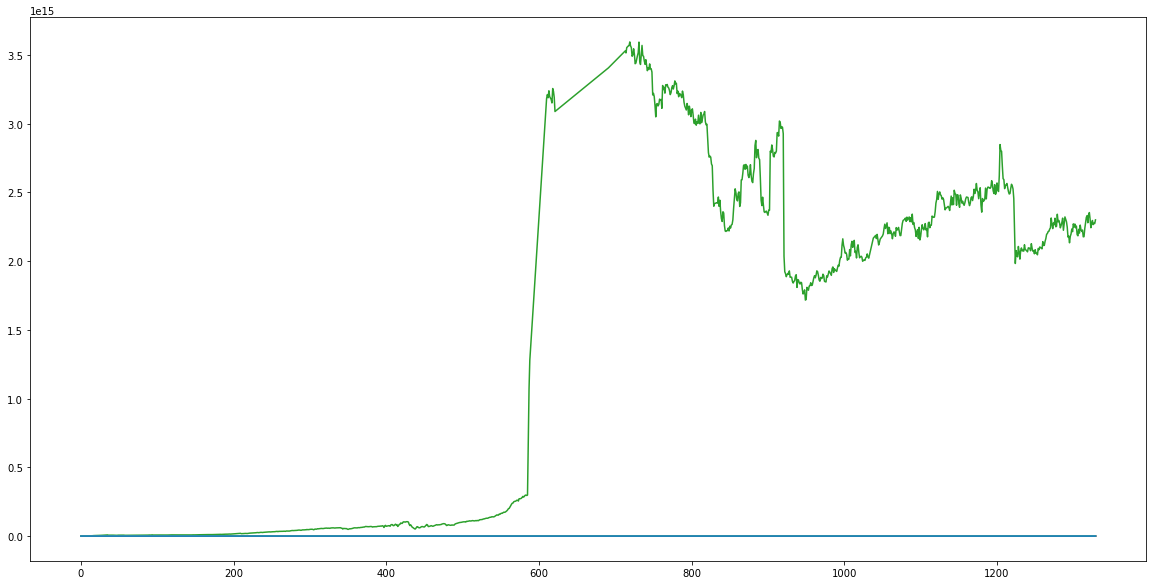

In [9]:
plt.plot(df_wo)
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#Con todas las metricas


X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMrktCurUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','HashRate','IssContNtv','IssContPctAnn','IssContUSD','IssTotNtv','IssTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [27]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.862e+05
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:13:20   Log-Likelihood:                -755.80
No. Observations:                 601   AIC:                             1556.
Df Residuals:                     579   BIC:                             1652.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0002   1.02

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## De 40 variables a 31

In [28]:
df_regresion_wo = df_wo.drop(['BlkCnt','FeeTotNtv','FeeTotUSD','NVTAdj','ROI1yr','ROI30d','SplyExpFut10yrCMBI','TxTfrValMeanNtv','VtyDayRet180d'], axis=1)

In [10]:
x = df_wo.values
#x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_wo.columns
#df.columns = df_regresion_wo.columns

In [11]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [11] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [4] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [12]:
print(out['topfeat'])

      PC          feature   loading  type
0    PC1         DiffMean  0.444999  best
1    PC2     VtyDayRet30d  0.953971  best
2    PC3  TxTfrValMeanUSD  0.521459  best
3    PC4  TxTfrValMeanUSD  0.679569  best
4    PC5        FeeTotNtv  0.767652  best
5    PC6         DiffMean  0.643166  best
6    PC7         TxTfrCnt -0.611232  best
7    PC8        AdrActCnt  0.721102  best
8    PC9      TxTfrValUSD  0.649269  best
9   PC10           SplyFF  0.711022  best
10  PC11         PriceUSD  0.706222  best
11  PC11    CapMrktCurUSD -0.685242  weak
12  PC10          SplyCur -0.670213  weak


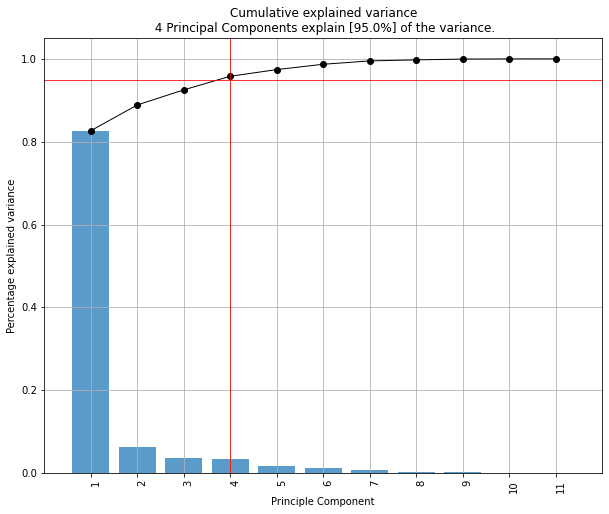

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae24f40d60>)

<Figure size 1440x720 with 0 Axes>

In [13]:
model.plot()

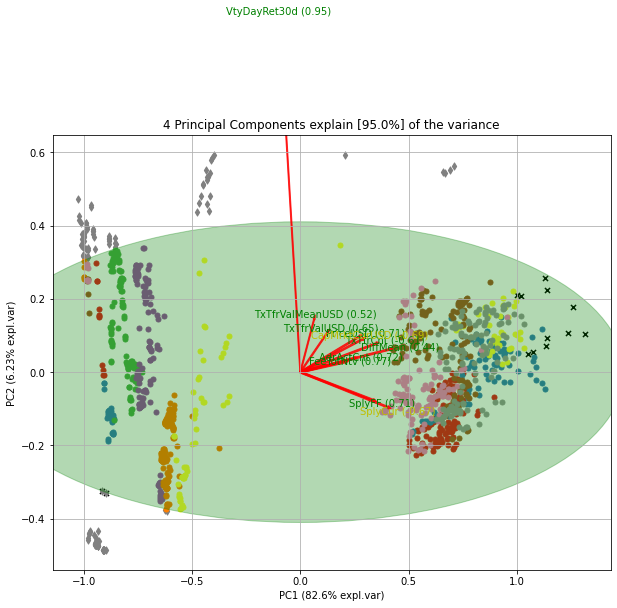

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae24ec4820>)

In [14]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

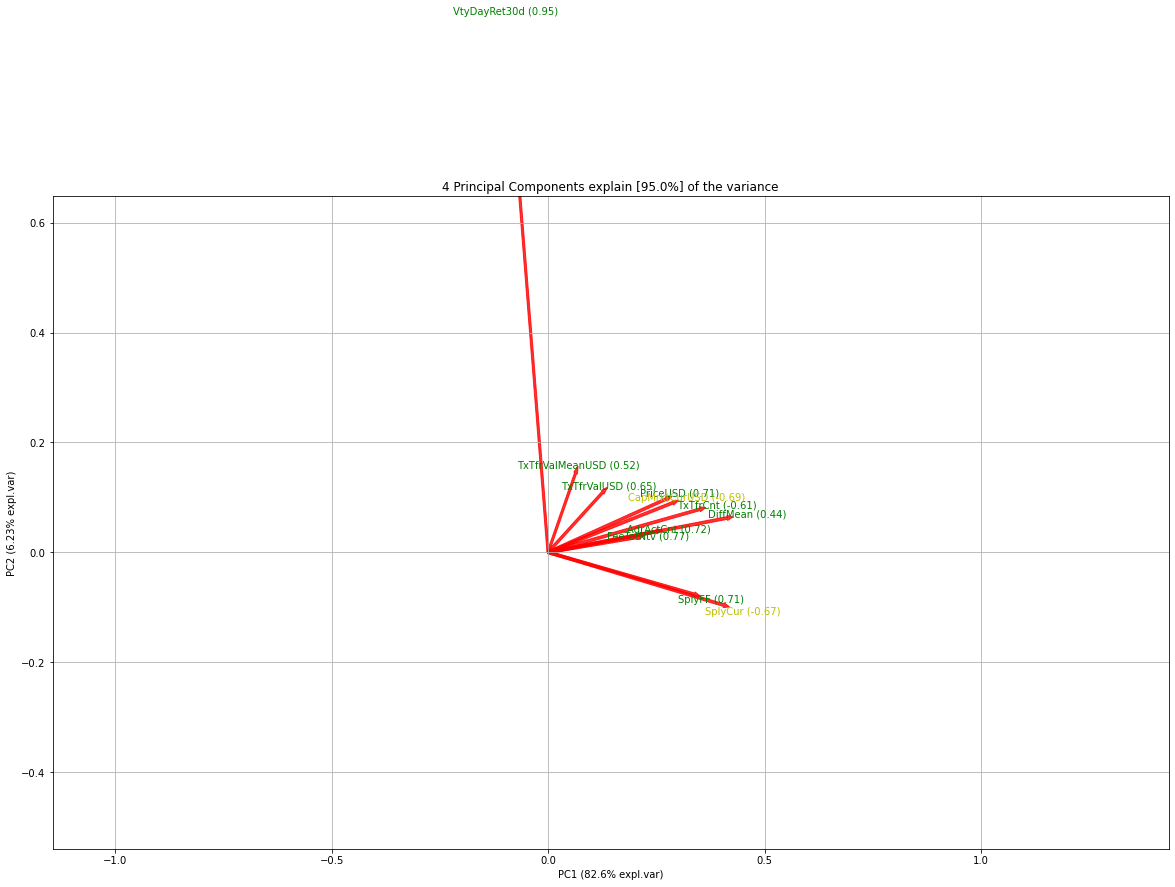

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae2402d0a0>)

In [15]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

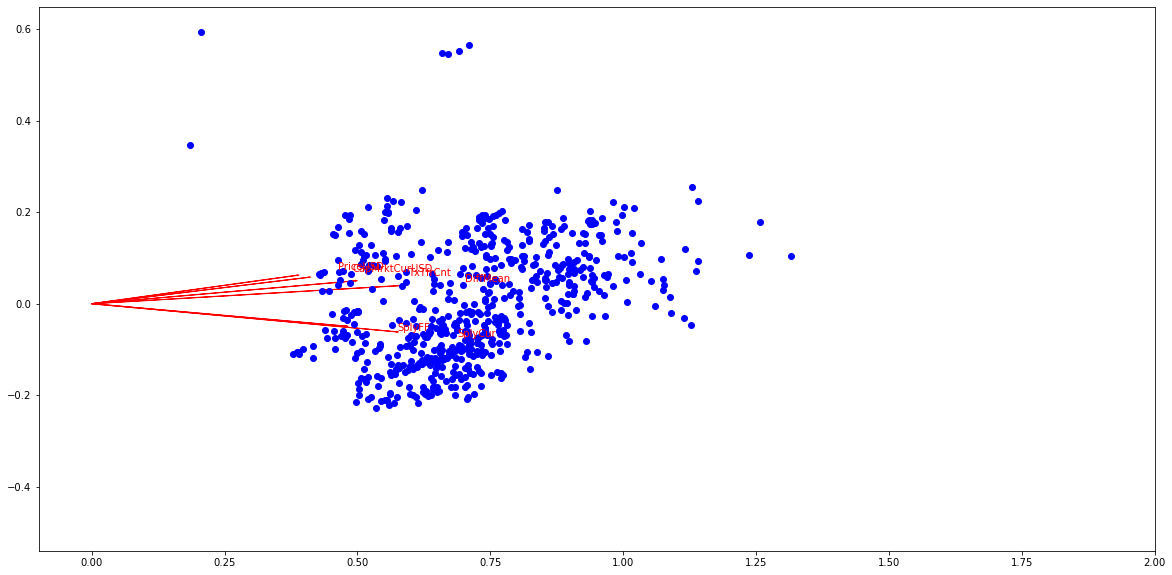

array(['CapMrktCurUSD', 'DiffMean', 'PriceUSD', 'SplyCur', 'SplyFF',
       'TxTfrCnt'], dtype=object)

In [19]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values)
#print(df.columns.values[17]) #vector priceUSD
#print(xvector[14])
plt.xlim(-0.1,2)
lim = np.sqrt(xvector[3]**2 + yvector[3]**2)
#lim = 1
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim and np.sign(xvector[i]) == np.sign(xvector[3])):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 6**

In [20]:
df_red = df[df.columns.values[feat]].copy()
#df_red = df_red.drop(['PriceBTC'],axis =1)

In [28]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
#rslt = df_red.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d
AdrActCnt,1.00,0.96,0.97,0.95,0.94,0.96,0.95,0.99,0.61,0.87,0.42
CapMrktCurUSD,0.96,1.00,0.95,1.00,0.92,0.93,0.93,0.96,0.62,0.88,0.42
DiffMean,0.97,0.95,1.00,0.95,0.94,0.96,0.95,0.97,0.59,0.84,0.41
PriceUSD,0.95,1.00,0.95,1.00,0.92,0.93,0.92,0.96,0.63,0.88,0.41
FeeTotNtv,0.94,0.92,0.94,0.92,1.00,0.92,0.92,0.95,0.60,0.85,0.40
SplyCur,0.96,0.93,0.96,0.93,0.92,1.00,1.00,0.96,0.64,0.85,0.48
SplyFF,0.95,0.93,0.95,0.92,0.92,1.00,1.00,0.95,0.64,0.85,0.48
TxTfrCnt,0.99,0.96,0.97,0.96,0.95,0.96,0.95,1.00,0.63,0.89,0.41
TxTfrValMeanUSD,0.61,0.62,0.59,0.63,0.60,0.64,0.64,0.63,1.00,0.79,0.28
TxTfrValUSD,0.87,0.88,0.84,0.88,0.85,0.85,0.85,0.89,0.79,1.00,0.34


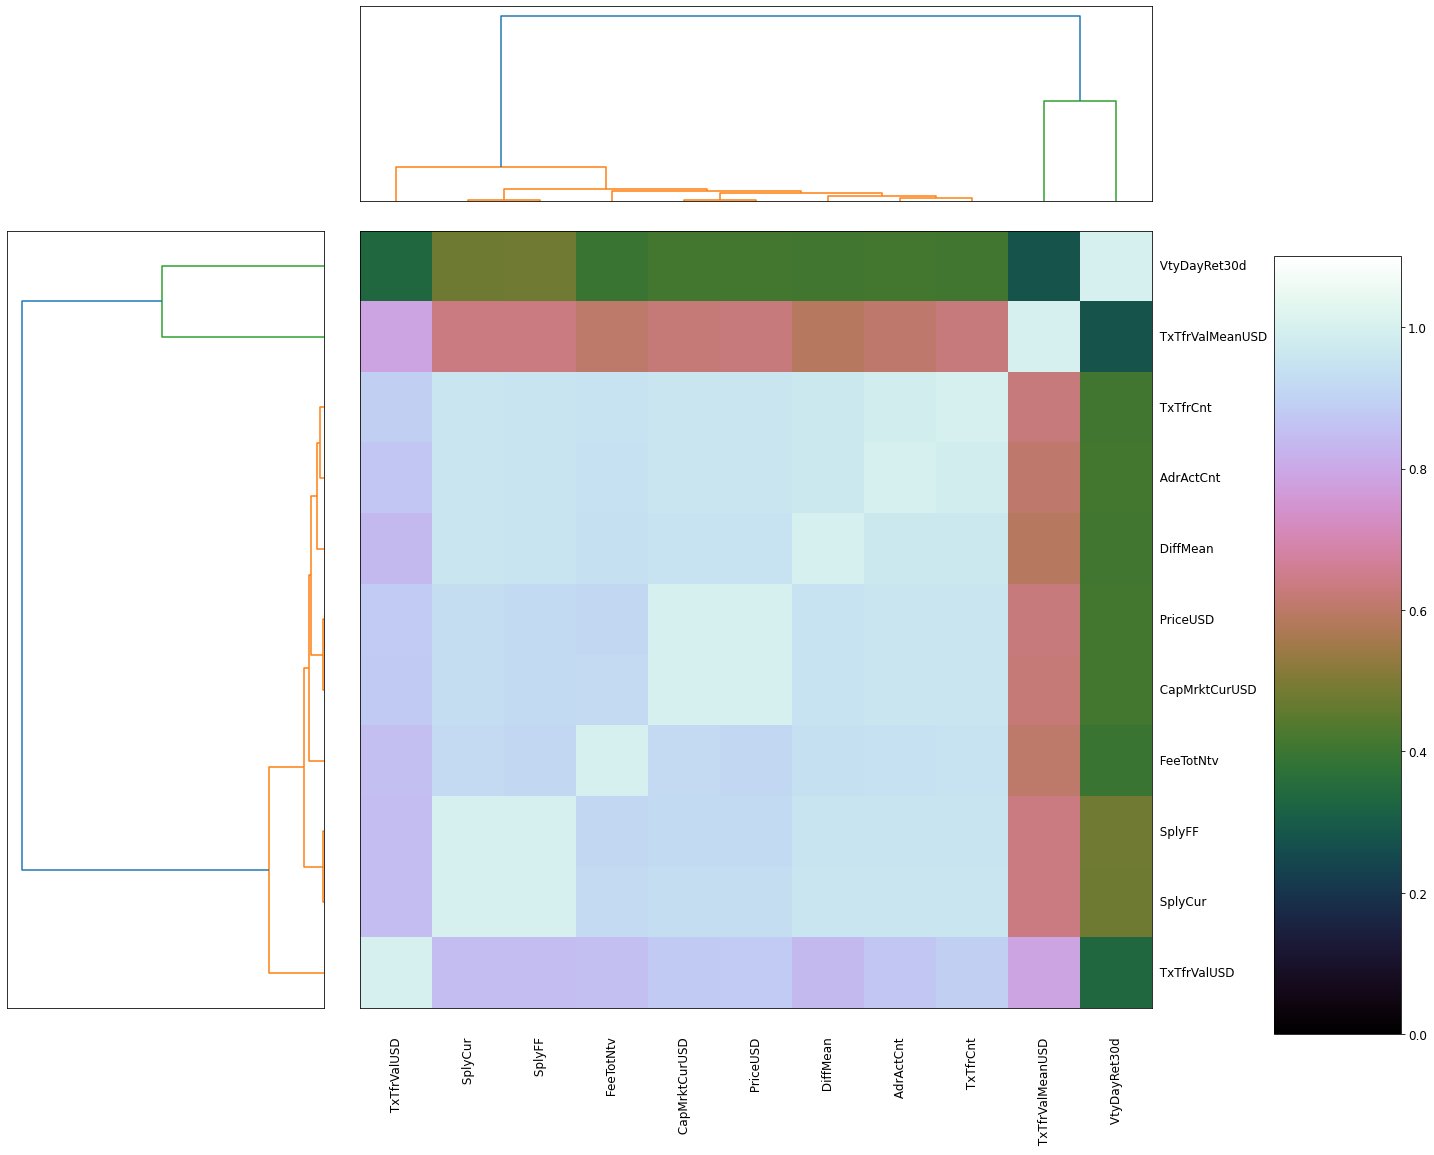

In [29]:
from biokit.viz import heatmap

df_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('ETH2_dendograma.png', dpi = 100)